<a href="https://colab.research.google.com/github/apchavezr/19.-Procesamiento-del-Lenguaje-Natural/blob/main/PLN_Tokenizacion_Bogota.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tokenización Word vs. BPE en PQRD de Bogotá

Este cuaderno reproduce el análisis didáctico paso a paso. Ejecute las celdas en orden.

                       Word         BPE
n               1000.000000  1000.00000
media             10.594000    13.18100
mediana           11.000000    13.00000
desviación_std     1.808434     1.62631
p5                 8.000000    10.00000
p95               14.000000    16.00000


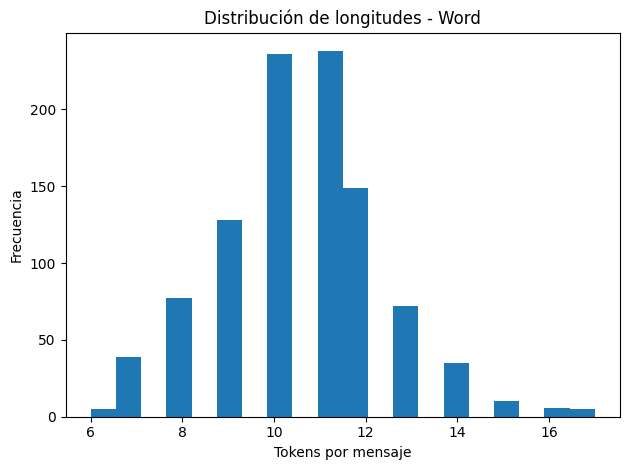

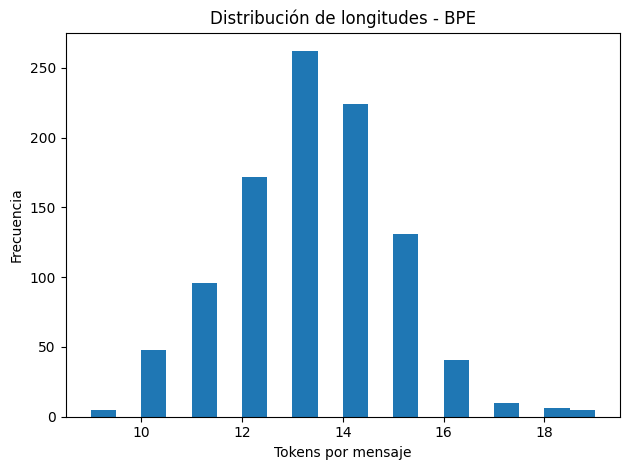

In [1]:

# Preparación de entorno
import re, random, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
try:
    from tokenizers import ByteLevelBPETokenizer
    HAS_TOKENIZERS = True
except Exception:
    HAS_TOKENIZERS = False

BASE = Path(".")
random.seed(123); np.random.seed(123)

# Corpus
localidades = ["Suba","Usaquén","Chapinero","Santa Fe","San Cristóbal","Usme","Tunjuelito","Bosa","Kennedy","Fontibón","Engativá","Barrios Unidos","Teusaquillo","Los Mártires","Antonio Nariño","Puente Aranda","La Candelaria","Rafael Uribe","Ciudad Bolívar","Sumapaz"]
vias = ["Cra. 7","Cra. 13","Cra. 30","Cl. 26","Cl. 72","Av. Boyacá","Av. Suba","Av. Caracas","Av. 68","Autop. Norte","Autop. Sur"]
asuntos = ["fuga de agua","daño de alumbrado","recolección de residuos","ruido nocturno","árbol caído","señalización vial","bache en la vía","acumulación de escombros","mal olor","parque en mal estado","semáforo dañado","inseguridad","venta informal","corte de agua"]
conectores = ["cerca de","a la altura de","frente a","entre","junto a","sobre"]
plantillas = [
    "Se reporta {asunto} en {localidad} {conector} {via}.",
    "Solicitud de atención por {asunto} en {via}, {localidad}.",
    "Ciudadanía informa {asunto} {conector} {via} en {localidad}.",
    "PQR por {asunto} en {localidad}, vía {via}.",
    "Confirman {asunto} en {via} ({localidad}).",
    "Se requiere intervención por {asunto} {conector} {via} en {localidad}.",
    "Reporte: {asunto} en {localidad} cerca de {via}."
]
def gen():
    import random
    return random.choice(plantillas).format(asunto=random.choice(asuntos), localidad=random.choice(localidades), conector=random.choice(conectores), via=random.choice(vias))
corpus = [gen() for _ in range(1000)]

# Tokenización Word
import re
word_pattern = re.compile(r"[A-Za-zÁÉÍÓÚÜÑáéíóúüñ0-9]+(?:\.[A-Za-z0-9]+)*", re.UNICODE)
def word_tok(t):
    toks = word_pattern.findall(t)
    out = []
    for tok in toks:
        if tok.endswith(".") and len(tok)>1:
            out.append(tok[:-1]); out.append(".")
        else:
            out.append(tok)
    return out
tokens_word = [word_tok(t) for t in corpus]
len_word = [len(t) for t in tokens_word]

# Tokenización BPE o pseudo-BPE
if HAS_TOKENIZERS:
    from pathlib import Path
    tmp = Path("./bpe_tmp"); tmp.mkdir(exist_ok=True)
    with open(tmp/"corpus.txt","w",encoding="utf-8") as f:
        for line in corpus: f.write(line+"\n")
    tok = ByteLevelBPETokenizer()
    tok.train(files=[str(tmp/"corpus.txt")], vocab_size=3000, min_frequency=2, special_tokens=["<s>","<pad>","</s>","<unk>","<mask>"])
    tokens_bpe = [tok.encode(t).tokens for t in corpus]
else:
    abrev_pat = re.compile(r"(Cra\.|Cl\.|Av\.)\s*\d+|Av\. [A-Za-zÁÉÍÓÚÜÑáéíóúüñ]+", re.UNICODE)
    def pseudo_bpe(text):
        toks, used = [], [False]*len(text)
        for m in abrev_pat.finditer(text):
            s,e = m.span()
            toks.append(text[s:e].strip())
            for i in range(s,e): used[i]=True
        rem = text
        for m in abrev_pat.finditer(text):
            s,e = m.span()
            rem = rem[:s] + " "*(e-s) + rem[e:]
        toks += word_pattern.findall(rem)
        return toks
    tokens_bpe = [pseudo_bpe(t) for t in corpus]
len_bpe = [len(t) for t in tokens_bpe]

# Resumen y gráficas
import numpy as np, pandas as pd, matplotlib.pyplot as plt
def resumen(x):
    return {"n":len(x),"media":float(np.mean(x)),"mediana":float(np.median(x)),"desviación_std":float(np.std(x,ddof=1)),"p5":float(np.percentile(x,5)),"p95":float(np.percentile(x,95))}
df = pd.DataFrame({"Word":resumen(len_word),"BPE":resumen(len_bpe)})
print(df)

plt.figure(); plt.hist(len_word, bins=20); plt.title("Distribución de longitudes - Word"); plt.xlabel("Tokens por mensaje"); plt.ylabel("Frecuencia"); plt.tight_layout(); plt.show()
plt.figure(); plt.hist(len_bpe, bins=20); plt.title("Distribución de longitudes - BPE"); plt.xlabel("Tokens por mensaje"); plt.ylabel("Frecuencia"); plt.tight_layout(); plt.show()
